In [1]:
import pandas as pd
import numpy as np
import matplotlib.colors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import LeaveOneOut
from collections import Counter
import seaborn


%matplotlib inline

In [2]:
data_cam_df = pd.read_csv('xcms_pigs_camera.csv', sep = ',', index_col=0)

In [3]:
service_cols = ["mz", "mzmin", "mzmax", "rt", "rtmin", "rtmax", ".", "npeaks", "isotopes", "adduct", "pcgroup"]
assert len(set(service_cols) - set(data_cam_df.columns))==0
samples_cols = list(set(data_cam_df.columns) - set(service_cols))

In [4]:
data_cam_df[data_cam_df==0]=np.nan
data_cam_df[samples_cols] = np.log(data_cam_df[samples_cols])

## standards

#### TAG

In [5]:
new_mz_palm = np.abs((data_cam_df['mz'] - 811.765)) / 811.765 
new_mz_palm = new_mz_palm * 1000000
sunf_ppm_palm = data_cam_df[new_mz_palm<13]

In [6]:
sunf_ppm_palm.head()
sunf_ppm_palm.index

Int64Index([2011], dtype='int64')

In [7]:
RO=pd.Series([i.split('_')[3][1:] if 'S' in i else i for i in data_cam_df.columns],index=data_cam_df.columns)

In [8]:
for i in RO.index:
    try:
        RO[i]=int(RO[i])
    except:
        RO[i]=np.nan

In [9]:
RO=RO.dropna()

In [10]:
rt_in_min = data_cam_df['rt']/60
data_cam_df['rt'] = rt_in_min
data_cam_filt_rt_df = data_cam_df[(data_cam_df['rt'] > 0.6) & (data_cam_df['rt'] < 19)]
data_cam_filt_rt_df.head(4)

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171206_pigs_scat1_3_15_pos_1.100,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_15_1.100_pos,X171208_pigs_scat2_18_1.100_pos,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup
1,130.158684,130.158150,130.159207,0.660983,38.049,127.265,79,75,11.640429,12.005639,...,11.927535,11.867717,12.015332,12.048855,11.646204,12.103320,11.972464,NaN,NaN,105
2,133.100423,133.099922,133.101013,3.391133,202.231,204.805,69,69,10.248525,11.050215,...,10.273095,9.808182,10.138165,9.222282,10.018860,10.075920,9.181783,NaN,[M+3H-C6H10O4]3+ 542.333,37
3,147.064214,147.063614,147.064651,0.970192,56.181,61.209,74,73,11.269131,8.689696,...,9.952731,9.736448,10.247801,9.891781,10.268355,9.772705,9.975347,NaN,[M+3H-CH2]3+ 452.189 [M+2H-C6H8O6]2+ 468.159,17
4,149.022196,149.021515,149.022699,4.672275,268.144,286.492,140,75,14.002570,13.957953,...,14.030105,14.237696,14.040697,14.005739,14.212340,14.243009,14.031754,NaN,NaN,61


In [11]:
del_isotopes = data_cam_filt_rt_df['isotopes'].str.match(r'\[\d+\]\[M\+\d+\]\+').fillna(False)
#[m][M+n]+ где n от 1, m from 1
data_cam_filt_rt_iso_df = data_cam_filt_rt_df[~del_isotopes]

### after Anya filtering

In [12]:
filtering_res = np.load('cleanedpeaks.npy')

In [13]:
filtering_res_indices = sorted(set(data_cam_filt_rt_iso_df.index) & set(filtering_res))

In [14]:
data_filtering = data_cam_filt_rt_iso_df.loc[filtering_res_indices]

In [15]:
annot_data = pd.read_csv('xcms_pigs_camera.csv.ann.txt', sep = ',', index_col=0)
#loading data

In [16]:
lmfa_index = annot_data['lm_id'].str.contains('LMFA0101').fillna(False)
#строки в annot_data которые содержать LMFA0101 + что-то
lmfa_annot_data = annot_data[lmfa_index]
lmfa_annot_data = annot_data[lmfa_index]
#беру из annot_data строки которые соответствуют строкам в которых есть LMFA0101 + что-то

In [17]:
annot_data_no_null = annot_data[~annot_data['lm_id'].isnull()]

In [18]:
annot_groups = []

for index, data in annot_data_no_null.groupby(annot_data_no_null.index):
    annot_groups.append({
        "index": index,
        "lm_id": ";".join(data.lm_id),
        "adduct_annot": ";".join(data.adduct)
    })
    
annot_groups = pd.DataFrame(annot_groups)
annot_groups.set_index('index', inplace=True)

In [19]:
data_cam_filt_rt_iso_df_annot = pd.merge(data_cam_filt_rt_iso_df, annot_groups, left_index=True, right_index=True)
data_cam_filt_rt_iso_df_annot

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171206_pigs_scat1_3_15_pos_1.100,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup,adduct_annot,lm_id
1,130.158684,130.158150,130.159207,0.660983,38.049,127.265,79,75,11.640429,12.005639,...,12.015332,12.048855,11.646204,12.103320,11.972464,NaN,NaN,105,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMFA11000592;LMFA11000636;LMFA11000637;LMFA110...
3,147.064214,147.063614,147.064651,0.970192,56.181,61.209,74,73,11.269131,8.689696,...,10.247801,9.891781,10.268355,9.772705,9.975347,NaN,[M+3H-CH2]3+ 452.189 [M+2H-C6H8O6]2+ 468.159,17,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H,LMFA01020278;LMFA01050343;LMFA01050383;LMFA010...
11,167.033147,167.032459,167.044086,4.664467,268.411,353.477,173,76,13.196349,12.749017,...,13.196748,13.158301,13.198074,13.357146,13.152200,NaN,[M+K]+ 128.075,61,M+Na;M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01020394;LMFA01170068;LMFA01170070;LMFA011...
23,189.111163,189.110486,189.111964,3.391100,202.502,204.732,76,75,11.039007,11.716192,...,10.897606,9.385198,10.667300,10.833208,8.944734,NaN,[M+2H-C5H8O4]2+ 508.248,37,M+H;M+H;M+H;M+H;M+H,LMFA01030981;LMFA01170054;LMFA07010695;LMFA070...
64,239.235633,239.234987,239.236786,3.651767,217.844,220.309,69,69,9.668170,10.678359,...,9.754414,10.162118,9.580330,9.686382,9.741953,NaN,NaN,48,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+...,LMFA05000007;LMFA05000015;LMFA05000023;LMFA050...
77,247.241090,247.239985,247.241918,3.829300,207.270,233.417,122,71,11.970738,12.069558,...,12.517894,13.089057,12.177053,12.927467,12.069352,NaN,NaN,111,M+H;M+H,LMFA11000057;LMPR0103500002
80,249.111112,249.109942,249.111911,2.736883,162.912,165.385,68,68,10.092041,8.713289,...,10.278754,10.091371,9.983209,9.925269,10.157924,NaN,NaN,74,M+Na;M+Na;M+Na;M+Na,LMFA01170130;LMFA02020007;LMFA02020008;LMFA020...
88,253.088412,253.087189,253.089254,15.456933,896.979,951.987,166,70,9.976485,10.203494,...,10.141990,10.267574,8.180022,10.216156,10.443502,NaN,NaN,1,M+H;M+H;M+H,LMPK12050001;LMPK12110021;LMPK12110100
95,259.189212,259.188321,259.190360,4.799233,273.364,291.272,72,67,10.914870,10.758726,...,11.093819,10.375224,10.442637,11.359048,10.443721,NaN,NaN,421,M+H;M+H;M+H;M+H;M+H;M+H,LMFA01170015;LMFA01170016;LMFA01170017;LMFA011...
98,261.147355,261.146258,261.148370,4.672900,268.374,286.852,139,75,12.158058,11.661869,...,12.222774,12.146986,12.148198,12.093720,12.165402,NaN,NaN,61,M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01060185;LMFA02010010;LMFA02010011;LMFA070...


In [20]:
data_cam_filt_rt_iso_df_annot.drop(["X171208_pigs_scat1_1_15_1.100_pos", "X171208_pigs_scat1_2_15_1.100_pos"], axis = 1, inplace = True)
data_cam_filt_rt_iso_df_annot.rename(columns={"X171208_pigs_LM3_1_11_1.50_pos": "X171208_pigs_LM3_11_1.50_pos",
                                             "X171206_pigs_scat1_3_15_pos_1.100": "X171208_pigs_scat1_15_1.100_pos"}, inplace=True)

## vSYAKOE

In [21]:
data_cam_filt_rt_iso_df_annot

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171208_pigs_scat1_15_1.100_pos,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup,adduct_annot,lm_id
1,130.158684,130.158150,130.159207,0.660983,38.049,127.265,79,75,11.640429,12.005639,...,12.015332,12.048855,11.646204,12.103320,11.972464,NaN,NaN,105,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMFA11000592;LMFA11000636;LMFA11000637;LMFA110...
3,147.064214,147.063614,147.064651,0.970192,56.181,61.209,74,73,11.269131,8.689696,...,10.247801,9.891781,10.268355,9.772705,9.975347,NaN,[M+3H-CH2]3+ 452.189 [M+2H-C6H8O6]2+ 468.159,17,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H,LMFA01020278;LMFA01050343;LMFA01050383;LMFA010...
11,167.033147,167.032459,167.044086,4.664467,268.411,353.477,173,76,13.196349,12.749017,...,13.196748,13.158301,13.198074,13.357146,13.152200,NaN,[M+K]+ 128.075,61,M+Na;M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01020394;LMFA01170068;LMFA01170070;LMFA011...
23,189.111163,189.110486,189.111964,3.391100,202.502,204.732,76,75,11.039007,11.716192,...,10.897606,9.385198,10.667300,10.833208,8.944734,NaN,[M+2H-C5H8O4]2+ 508.248,37,M+H;M+H;M+H;M+H;M+H,LMFA01030981;LMFA01170054;LMFA07010695;LMFA070...
64,239.235633,239.234987,239.236786,3.651767,217.844,220.309,69,69,9.668170,10.678359,...,9.754414,10.162118,9.580330,9.686382,9.741953,NaN,NaN,48,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+...,LMFA05000007;LMFA05000015;LMFA05000023;LMFA050...
77,247.241090,247.239985,247.241918,3.829300,207.270,233.417,122,71,11.970738,12.069558,...,12.517894,13.089057,12.177053,12.927467,12.069352,NaN,NaN,111,M+H;M+H,LMFA11000057;LMPR0103500002
80,249.111112,249.109942,249.111911,2.736883,162.912,165.385,68,68,10.092041,8.713289,...,10.278754,10.091371,9.983209,9.925269,10.157924,NaN,NaN,74,M+Na;M+Na;M+Na;M+Na,LMFA01170130;LMFA02020007;LMFA02020008;LMFA020...
88,253.088412,253.087189,253.089254,15.456933,896.979,951.987,166,70,9.976485,10.203494,...,10.141990,10.267574,8.180022,10.216156,10.443502,NaN,NaN,1,M+H;M+H;M+H,LMPK12050001;LMPK12110021;LMPK12110100
95,259.189212,259.188321,259.190360,4.799233,273.364,291.272,72,67,10.914870,10.758726,...,11.093819,10.375224,10.442637,11.359048,10.443721,NaN,NaN,421,M+H;M+H;M+H;M+H;M+H;M+H,LMFA01170015;LMFA01170016;LMFA01170017;LMFA011...
98,261.147355,261.146258,261.148370,4.672900,268.374,286.852,139,75,12.158058,11.661869,...,12.222774,12.146986,12.148198,12.093720,12.165402,NaN,NaN,61,M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01060185;LMFA02010010;LMFA02010011;LMFA070...


In [22]:
all_columns = data_cam_filt_rt_iso_df_annot.columns.tolist()
samples_columns = all_columns[all_columns.index('X171208_pigs_scat1_15_1.100_pos'):all_columns.index('X171208_pigs_scat2_9_1.100_pos')+1]

In [23]:
data_annot_norm = data_cam_filt_rt_iso_df_annot.copy()
data_annot_norm[samples_columns] =  data_annot_norm[samples_columns] /  data_annot_norm[samples_columns].max()

In [24]:
def select_columns(columns, parts):
    return [col for col in columns if any(part in col for part in parts)]

meat_columns = select_columns(samples_columns, ["BF1", "BF2", "BF3", "LM1", "LM2", "LM3"])
fat_columns = select_columns(samples_columns, ["scat1", "scat2"])

In [25]:
mean_meat_sample = data_annot_norm[meat_columns].mean(axis=1)
mean_fat_sample = data_annot_norm[fat_columns].mean(axis = 1)

In [26]:
def count_lipids(lipids_col):
    lipids = []
    for lipids_row in lipids_col:
        lipids.extend(lipids_row.split(";"))
    return Counter(lipids)

def get_top_lipids_for_sample(sample, n):
    top_indices = np.argsort(sample.values)[-n:]
    return count_lipids(data_annot_norm['lm_id'].iloc[top_indices])

def get_top_lipids_for_columns(columns, n):
    lipids_counter = Counter()
    for col in columns:
        lipids_counter.update(get_top_lipids_for_sample(data_annot_norm[col], n))
        
    lipids_counts = pd.Series(lipids_counter)
    lipids_counts /= len(columns)
    return lipids_counts.sort_values(ascending=False)
    
    

    

In [27]:
n_peaks = 50

In [28]:
top_meat_lipids = get_top_lipids_for_columns(meat_columns, n_peaks)
top_meat_lipids = list(zip(top_meat_lipids, top_meat_lipids.index))
top_meat_lipids

[(2.9038461538461537, 'LMGL03010310'),
 (2.9038461538461537, 'LMGL03016073'),
 (2.9038461538461537, 'LMGL03014784'),
 (2.9038461538461537, 'LMGL03013603'),
 (2.9038461538461537, 'LMGL03012859'),
 (2.9038461538461537, 'LMGL03010352'),
 (2.9038461538461537, 'LMGL03015471'),
 (2.9038461538461537, 'LMGL03015100'),
 (2.9038461538461537, 'LMGL03010416'),
 (2.9038461538461537, 'LMGL03014802'),
 (2.9038461538461537, 'LMGL03016143'),
 (2.9038461538461537, 'LMGL03016146'),
 (2.9038461538461537, 'LMGL03014431'),
 (2.9038461538461537, 'LMGL03010375'),
 (2.9038461538461537, 'LMGL03015428'),
 (2.9038461538461537, 'LMGL03015935'),
 (2.9038461538461537, 'LMGL03014819'),
 (2.9038461538461537, 'LMGL03014836'),
 (2.9038461538461537, 'LMGL03013622'),
 (2.9038461538461537, 'LMGL03016077'),
 (2.9038461538461537, 'LMGL03016017'),
 (2.9038461538461537, 'LMGL03014851'),
 (2.9038461538461537, 'LMGL03016015'),
 (2.9038461538461537, 'LMGL03014379'),
 (2.9038461538461537, 'LMGL03015741'),
 (2.9038461538461537, 'LM

In [29]:
top_fat_lipids = get_top_lipids_for_columns(fat_columns, n_peaks)
top_fat_lipids = list(zip(top_fat_lipids, top_fat_lipids.index))
top_fat_lipids

[(3.0, 'LMGL03014837'),
 (3.0, 'LMGL03014446'),
 (3.0, 'LMGL03010416'),
 (3.0, 'LMGL03014507'),
 (3.0, 'LMGL03014506'),
 (3.0, 'LMGL03013630'),
 (3.0, 'LMGL03014497'),
 (3.0, 'LMGL03014496'),
 (3.0, 'LMGL03016018'),
 (3.0, 'LMGL03010469'),
 (3.0, 'LMGL03010470'),
 (3.0, 'LMGL03010524'),
 (3.0, 'LMGL03010525'),
 (3.0, 'LMGL03010526'),
 (3.0, 'LMGL03013631'),
 (3.0, 'LMGL03013637'),
 (3.0, 'LMGL03013030'),
 (3.0, 'LMGL03013029'),
 (3.0, 'LMGL03013025'),
 (3.0, 'LMGL03014485'),
 (3.0, 'LMGL03015078'),
 (3.0, 'LMGL03015079'),
 (3.0, 'LMGL03013638'),
 (3.0, 'LMGL03010404'),
 (3.0, 'LMGL03010403'),
 (3.0, 'LMGL03010400'),
 (3.0, 'LMGL03010359'),
 (3.0, 'LMGL03010347'),
 (3.0, 'LMGL03010350'),
 (3.0, 'LMGL03010351'),
 (3.0, 'LMGL03010352'),
 (3.0, 'LMGL03010354'),
 (3.0, 'LMGL03010355'),
 (3.0, 'LMGL03010356'),
 (3.0, 'LMGL03010357'),
 (3.0, 'LMGL03010358'),
 (3.0, 'LMGL03010361'),
 (3.0, 'LMGL03010399'),
 (3.0, 'LMGL03013622'),
 (3.0, 'LMGL03010371'),
 (3.0, 'LMGL03010372'),
 (3.0, 'LMGL0301

In [30]:
logfc_fat_meat = np.log(mean_fat_sample/mean_meat_sample)

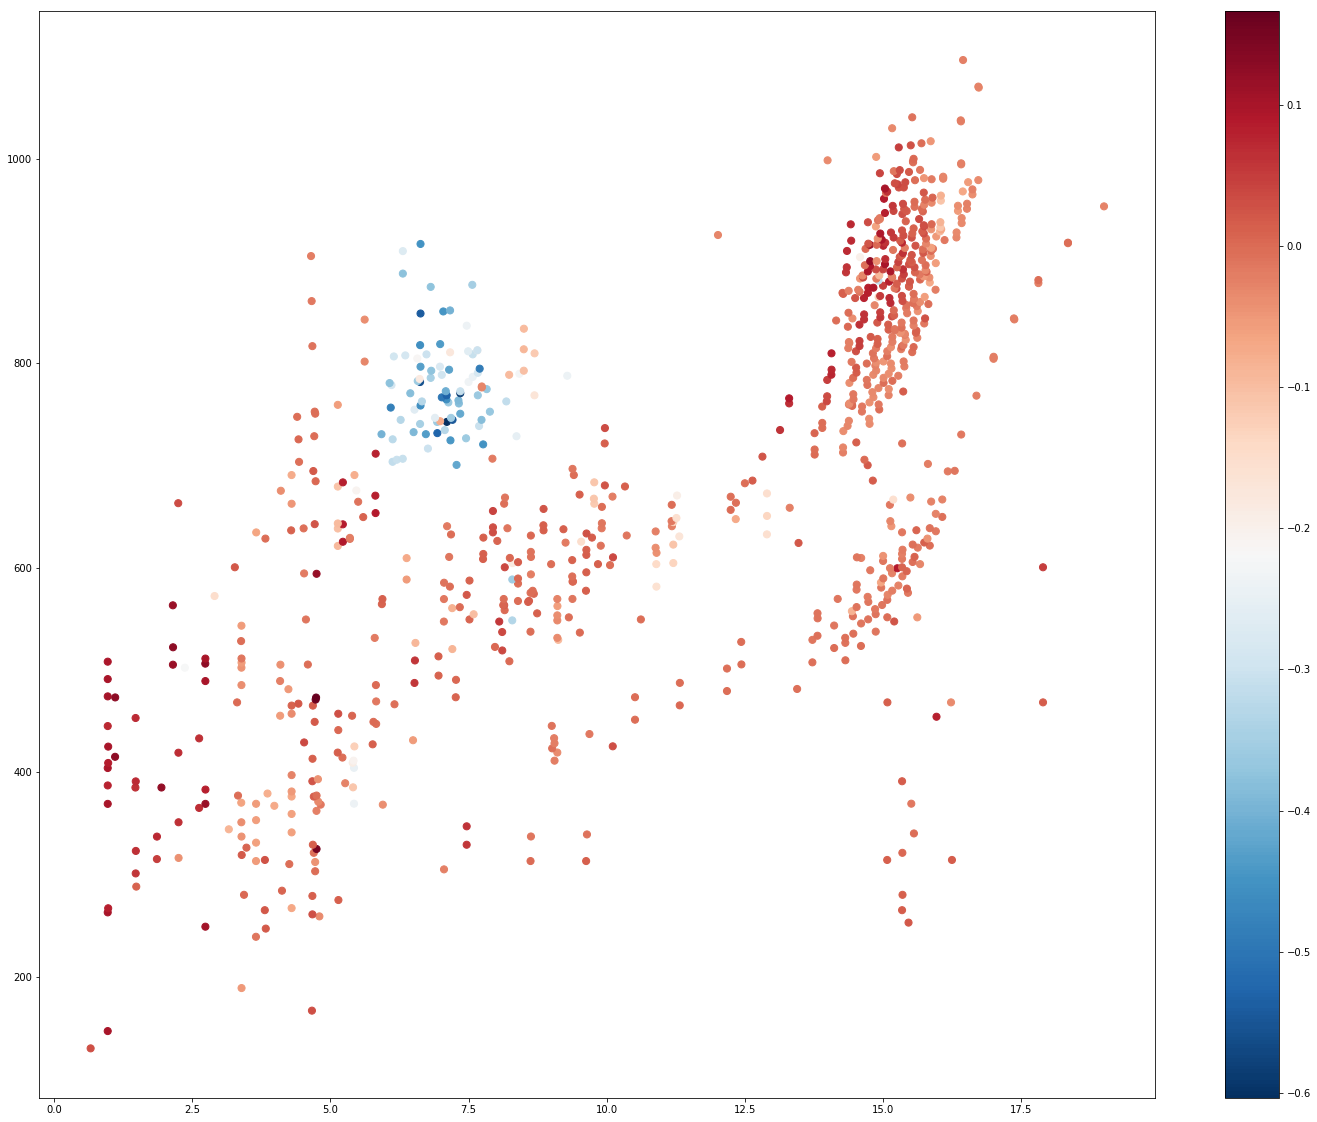

In [134]:
#cmap = seaborn.cubehelix_palette(as_cmap=True)
cmap = matplotlib.colors.ListedColormap(seaborn.color_palette("RdBu_r", 300).as_hex())
f, ax = plt.subplots()
points = ax.scatter(data_annot_norm['rt'], data_annot_norm['mz'], c=logfc_fat_meat, s=50, cmap=cmap)
f.colorbar(points)
f.set_size_inches(25,20)


In [32]:
count_lipids(data_annot_norm['lm_id'][logfc_fat_meat<=logfc_fat_meat.quantile(0.02)]).most_common()

[('LMGP01020015', 2),
 ('LMGP01020029', 2),
 ('LMGP01020195', 2),
 ('LMGP01020216', 2),
 ('LMGP01080023', 2),
 ('LMGP02020044', 2),
 ('LMGP02020065', 2),
 ('LMGP02020097', 2),
 ('LMGP01020041', 2),
 ('LMGP01020042', 2),
 ('LMGP01020257', 2),
 ('LMGP01030008', 2),
 ('LMGP01030135', 2),
 ('LMGP01030145', 2),
 ('LMGP01090010', 2),
 ('LMGP01090011', 2),
 ('LMGP01090021', 2),
 ('LMGP02030072', 2),
 ('LMGP01020039', 2),
 ('LMGP01030006', 2),
 ('LMGP01030053', 2),
 ('LMGP01030077', 2),
 ('LMGP01030128', 2),
 ('LMGP01030134', 2),
 ('LMGP01030144', 2),
 ('LMGP01090006', 2),
 ('LMGP01090007', 2),
 ('LMGP01090009', 2),
 ('LMGP01090012', 2),
 ('LMGP01090019', 2),
 ('LMGP02020070', 2),
 ('LMGP02030051', 2),
 ('LMGP02030071', 2),
 ('LMGP16010001', 2),
 ('LMGP10020034', 1),
 ('LMGP10020050', 1),
 ('LMGP10030023', 1),
 ('LMGP10030044', 1),
 ('LMGP10030064', 1),
 ('LMGP02020095', 1),
 ('LMGP02030049', 1),
 ('LMGP02030093', 1),
 ('LMGP10020090', 1),
 ('LMGP10030050', 1),
 ('LMGP01030024', 1),
 ('LMGP020

In [33]:
mean_scat1_sample = data_annot_norm[select_columns(samples_columns, ["scat1"])].mean(axis=1)
mean_scat2_sample = data_annot_norm[select_columns(samples_columns, ["scat2"])].mean(axis=1)

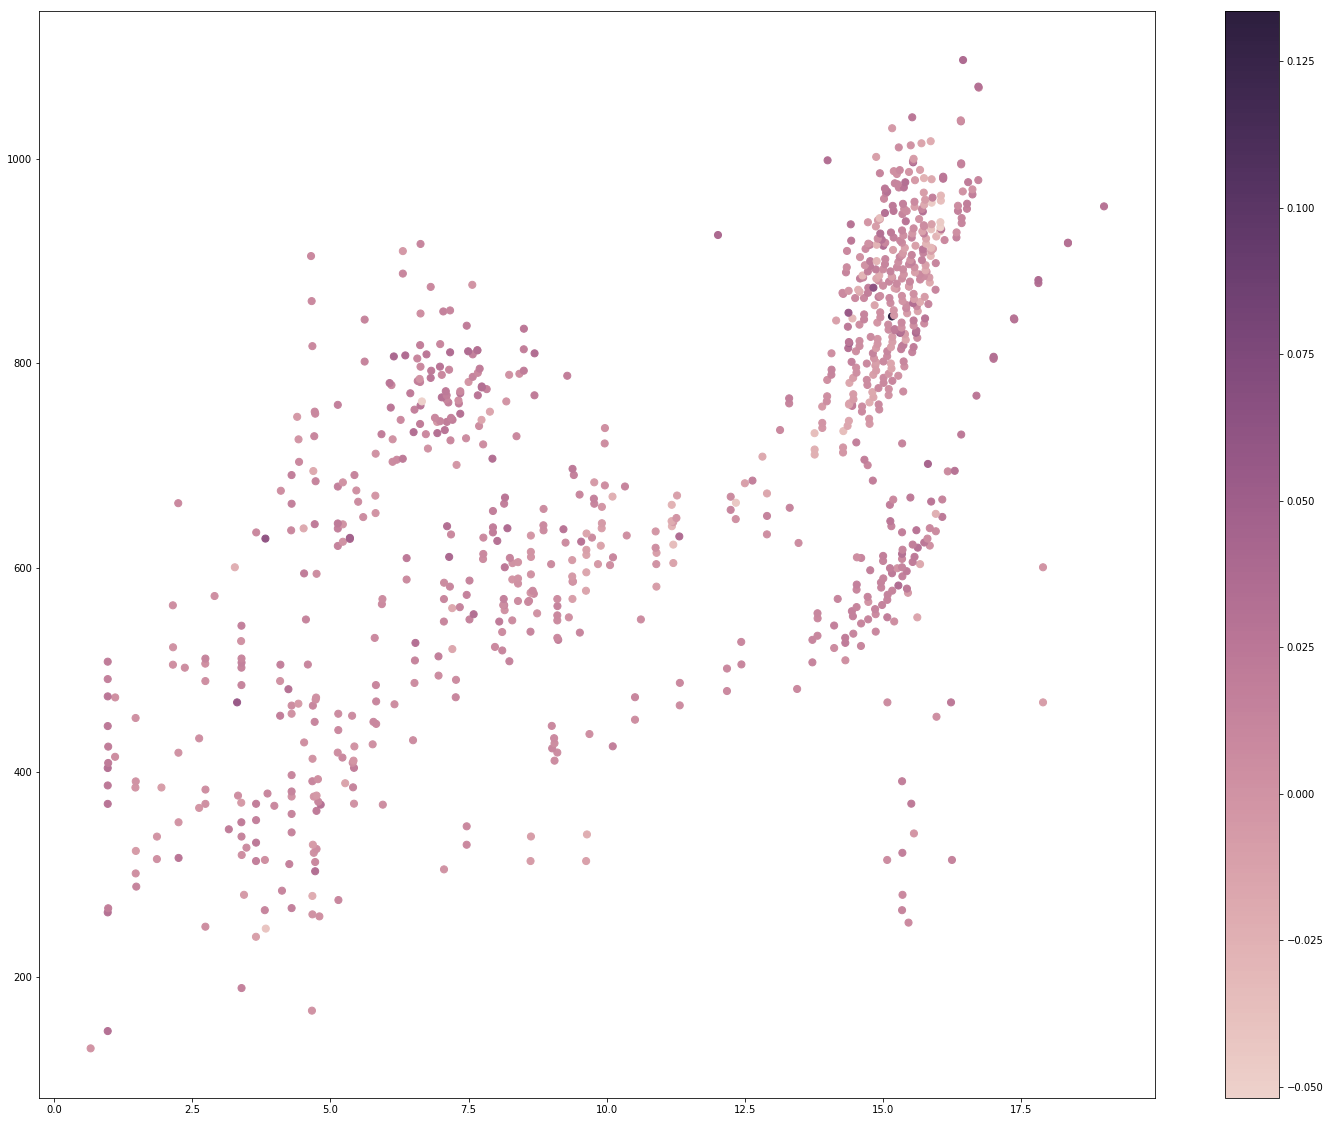

In [34]:
logfc_scat1_scat2 = np.log(mean_scat1_sample/mean_scat2_sample)

cmap = seaborn.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(data_annot_norm['rt'], data_annot_norm['mz'], c=logfc_scat1_scat2, s=50, cmap=cmap)
f.colorbar(points)
f.set_size_inches(25,20)


In [130]:
data_annot_norm.to_csv('data_annot_pigs.csv')

## MDS

In [69]:
import math
import pandas as pd
import numpy as np


In [57]:
data_ms_no_nan = data_mds.fillna(0)
data_ms_no_nan.isnull().any().any()

False

## MDS

In [62]:
data_ms_no_nan = data_ms_no_nan.iloc[:, 3:].corr()

In [63]:
data_ms_no_nan.shape

(72, 72)

In [65]:
from sklearn.manifold import MDS

In [67]:
pos = MDS(dissimilarity='precomputed', max_iter=3000, random_state=13).fit_transform(1-data_ms_no_nan)
pos = pos.T
pos = pd.DataFrame(pos, columns = data_ms_no_nan.columns)

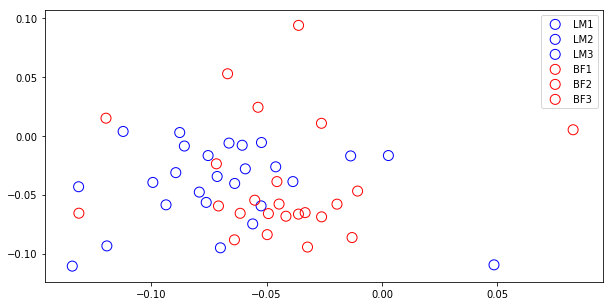

In [127]:
qc_cols = [col for col in pos.columns if 'QC' in col]
non_qc_cols = [col for col in pos.columns if 'QC' not in col]
scat1 = [col for col in pos.columns if 'scat1'in col]
scat2 = [col for col in pos.columns if 'scat2'in col]
LM1 = [col for col in pos.columns if 'LM1'in col]
LM1 = [col for col in pos.columns if 'LM1'in col]
LM2 = [col for col in pos.columns if 'LM2'in col]
LM3 = [col for col in pos.columns if 'LM3'in col]
BF1 = [col for col in pos.columns if 'BF1'in col]
BF2 = [col for col in pos.columns if 'BF2'in col]
BF3 = [col for col in pos.columns if 'BF3'in col]


plt.gcf().set_size_inches(10,5)
#plt.scatter(pos[non_qc_cols].iloc[0], pos[non_qc_cols].iloc[1], label='Non QC', s=100, facecolors='none', edgecolors='rebeccapurple')
plt.scatter(pos[LM1].iloc[0], pos[LM1].iloc[1], label='LM1', s=100, facecolors='none', edgecolors='Blue')
plt.scatter(pos[LM2].iloc[0], pos[LM2].iloc[1], label='LM2', s=100, facecolors='none', edgecolors='Blue')
plt.scatter(pos[LM3].iloc[0], pos[LM3].iloc[1], label='LM3', s=100, facecolors='none', edgecolors='Blue')
plt.scatter(pos[BF1].iloc[0], pos[BF1].iloc[1], label='BF1', s=100, facecolors='none', edgecolors='red')
plt.scatter(pos[BF2].iloc[0], pos[BF2].iloc[1], label='BF2', s=100, facecolors='none', edgecolors='red')
plt.scatter(pos[BF3].iloc[0], pos[BF3].iloc[1], label='BF3', s=100, facecolors='none', edgecolors='red')





#plt.scatter(pos[qc_cols].iloc[0], pos[qc_cols].iloc[1], label='QC', s=100, facecolors='none', edgecolors='black')
#plt.scatter(pos[scat1].iloc[0], pos[scat1].iloc[1], label='SCAT1', s=100, facecolors='none', edgecolors='red')
#plt.scatter(pos[scat2].iloc[0], pos[scat2].iloc[1], label='SCAT2', s=100, facecolors='none', edgecolors='Blue')

plt.legend()

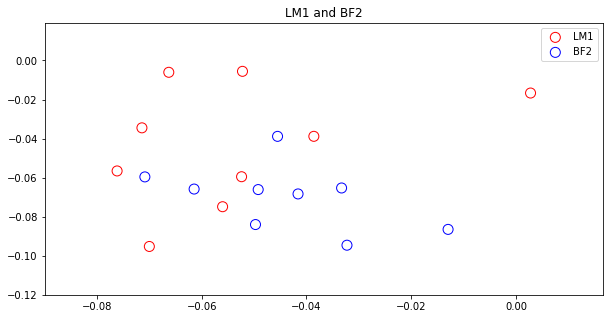

In [93]:
qc_cols = [col for col in pos.columns if 'QC' in col]
non_qc_cols = [col for col in pos.columns if 'QC' not in col]
scat1 = [col for col in pos.columns if 'LM1'in col]
scat2 = [col for col in pos.columns if 'BF2'in col]


plt.gcf().set_size_inches(10,5)
#plt.scatter(pos[non_qc_cols].iloc[0], pos[non_qc_cols].iloc[1], label='Non QC', s=100, facecolors='none', edgecolors='rebeccapurple')
#plt.scatter(pos[qc_cols].iloc[0], pos[qc_cols].iloc[1], label='QC', s=100, facecolors='none', edgecolors='black')
plt.scatter(pos[scat1].iloc[0], pos[scat1].iloc[1], label='LM1', s=100, facecolors='none', edgecolors='red')
plt.scatter(pos[scat2].iloc[0], pos[scat2].iloc[1], label='BF2', s=100, facecolors='none', edgecolors='Blue',)
plt.title('LM1 and BF2')
plt.legend()

## FAT TAGs

In [95]:
data_annot_norm

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171208_pigs_scat1_15_1.100_pos,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup,adduct_annot,lm_id
1,130.158684,130.158150,130.159207,0.660983,38.049,127.265,79,75,0.655597,0.650461,...,0.673950,0.676037,0.654682,0.679058,0.665878,NaN,NaN,105,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMFA11000592;LMFA11000636;LMFA11000637;LMFA110...
3,147.064214,147.063614,147.064651,0.970192,56.181,61.209,74,73,0.634686,0.470805,...,0.574807,0.555008,0.577227,0.548298,0.554804,NaN,[M+3H-CH2]3+ 452.189 [M+2H-C6H8O6]2+ 468.159,17,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H,LMFA01020278;LMFA01050343;LMFA01050383;LMFA010...
11,167.033147,167.032459,167.044086,4.664467,268.411,353.477,173,76,0.743228,0.690737,...,0.740216,0.738286,0.741919,0.749404,0.731492,NaN,[M+K]+ 128.075,61,M+Na;M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01020394;LMFA01170068;LMFA01170070;LMFA011...
23,189.111163,189.110486,189.111964,3.391100,202.502,204.732,76,75,0.621725,0.634779,...,0.611256,0.526585,0.599654,0.607798,0.497484,NaN,[M+2H-C5H8O4]2+ 508.248,37,M+H;M+H;M+H;M+H;M+H,LMFA01030981;LMFA01170054;LMFA07010695;LMFA070...
64,239.235633,239.234987,239.236786,3.651767,217.844,220.309,69,69,0.544518,0.578550,...,0.547133,0.570176,0.538550,0.543455,0.541823,NaN,NaN,48,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+...,LMFA05000007;LMFA05000015;LMFA05000023;LMFA050...
77,247.241090,247.239985,247.241918,3.829300,207.270,233.417,122,71,0.674201,0.653924,...,0.702139,0.734401,0.684523,0.725297,0.671267,NaN,NaN,111,M+H;M+H,LMFA11000057;LMPR0103500002
80,249.111112,249.109942,249.111911,2.736883,162.912,165.385,68,68,0.568391,0.472083,...,0.576544,0.566207,0.561198,0.556858,0.564958,NaN,NaN,74,M+Na;M+Na;M+Na;M+Na,LMFA01170130;LMFA02020007;LMFA02020008;LMFA020...
88,253.088412,253.087189,253.089254,15.456933,896.979,951.987,166,70,0.561883,0.552822,...,0.568872,0.576093,0.459833,0.573178,0.580841,NaN,NaN,1,M+H;M+H;M+H,LMPK12050001;LMPK12110021;LMPK12110100
95,259.189212,259.188321,259.190360,4.799233,273.364,291.272,72,67,0.614733,0.582904,...,0.622261,0.582133,0.587024,0.637300,0.580854,NaN,NaN,421,M+H;M+H;M+H;M+H;M+H;M+H,LMFA01170015;LMFA01170016;LMFA01170017;LMFA011...
98,261.147355,261.146258,261.148370,4.672900,268.374,286.852,139,75,0.684751,0.631836,...,0.685585,0.681543,0.682901,0.678519,0.676609,NaN,NaN,61,M+Na;M+Na;M+Na;M+Na;M+Na,LMFA01060185;LMFA02010010;LMFA02010011;LMFA070...


In [105]:
data_annot_norm
data_tag_rt = data_annot_norm[(data_annot_norm['rt'] > 13) & (data_annot_norm['rt'] < 17)]
data_tag_rtmz = data_tag_rt[(data_tag_rt['mz'] > 700) & (data_tag_rt['rt'] < 1100)]



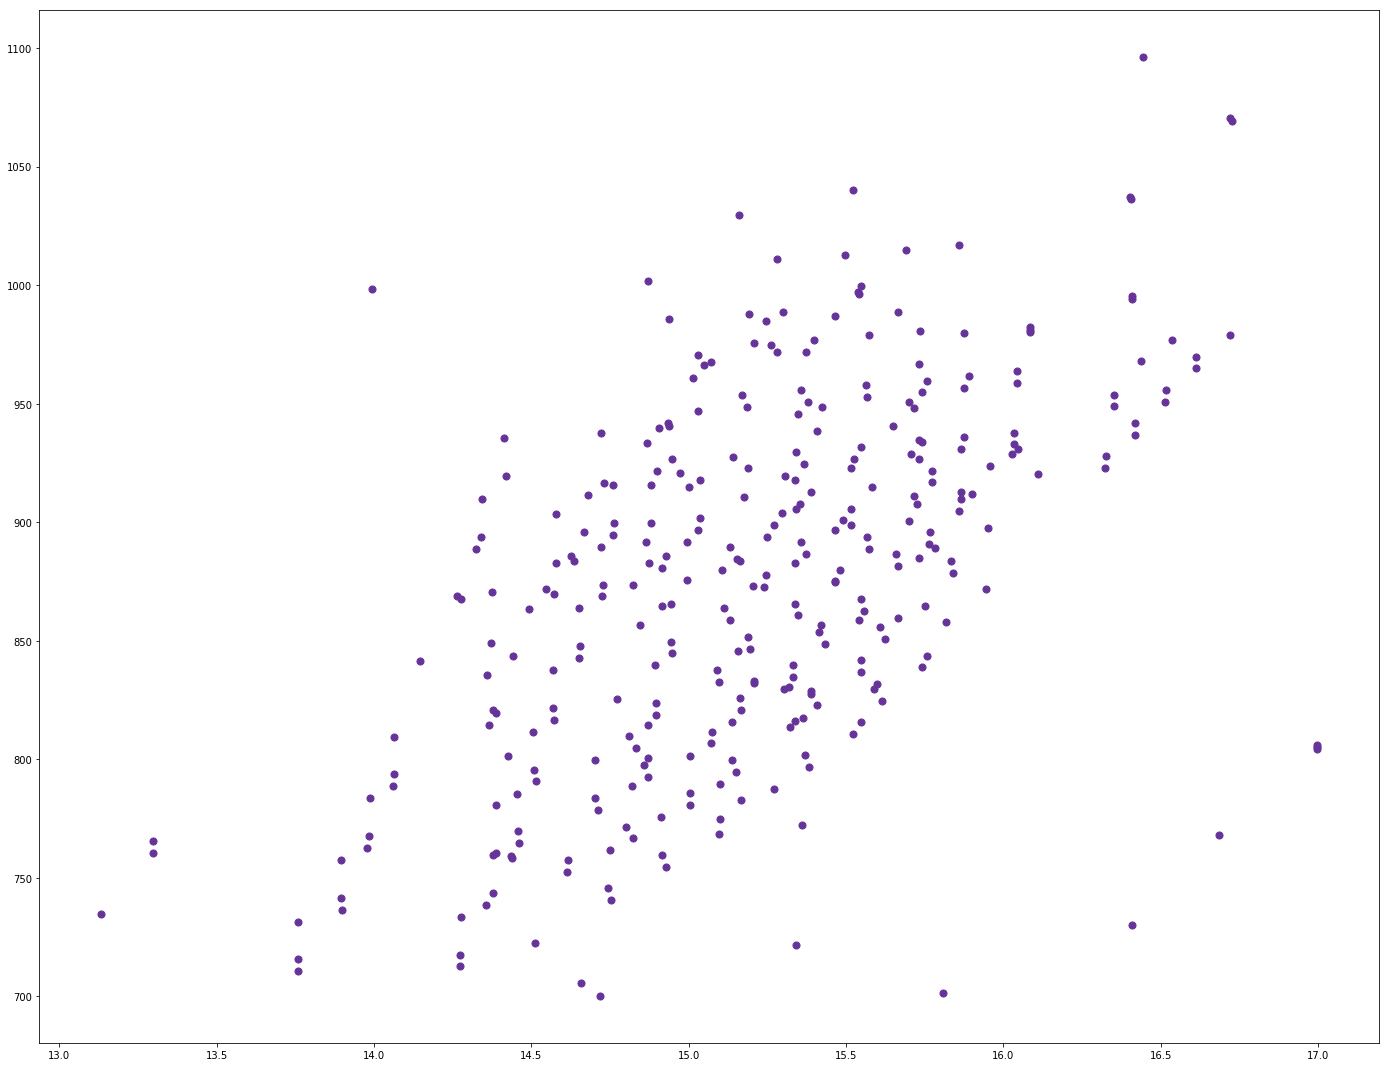

In [106]:

plt.gcf().set_size_inches(24,19)
plt.scatter(data_tag_rtmz['rt'], data_tag_rtmz['mz'], color = 'rebeccapurple', s = 50)

In [115]:
data_tag_rtmz

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171208_pigs_scat1_15_1.100_pos,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup,adduct_annot,lm_id
1563,700.251662,700.249215,700.254689,14.717683,881.164,883.815,75,75,0.562097,0.543680,...,0.561172,0.556646,0.562085,0.558173,0.556629,[329][M]+,NaN,27,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMPK12111226;LMPK12111264;LMPK12111407;LMPK121...
1571,701.491615,701.490091,701.495337,15.807900,893.820,973.553,117,56,0.718405,0.626496,...,0.656502,0.665925,0.653153,0.638709,0.650768,NaN,NaN,819,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMGP02010375;LMGP02010435;LMGP02010436;LMGP020...
1596,705.580863,705.577883,705.584671,14.659133,877.849,880.829,67,63,0.530534,0.522521,...,0.541977,0.525331,0.529911,0.532986,0.476751,NaN,NaN,67,M+H;M+H;M+H;M+H,LMGP10020015;LMGP10020033;LMGP10020049;LMST010...
1606,710.628200,710.619502,710.631196,13.758933,771.661,828.181,76,75,0.614370,0.625769,...,0.637201,0.616369,0.623169,0.634419,0.624194,[340][M]+,[M+H+NH3]+ 692.595,129,M+NH4;M+NH4;M+NH4;M+NH4,LMGL03012633;LMGL03012692;LMGL03013180;LMGL030...
1618,712.643653,712.641264,712.646902,14.272367,853.673,900.335,77,75,0.613369,0.613866,...,0.603350,0.600988,0.602548,0.609517,0.605982,NaN,NaN,505,M+NH4;M+NH4;M+NH4;M+NH4,LMGL03012632;LMGL03012660;LMGL03012691;LMGL030...
1620,715.583984,715.581310,715.587002,13.758383,823.887,828.181,74,73,0.589131,0.596423,...,0.610012,0.589327,0.597462,0.606634,0.595723,[343][M]+,[M+Na]+ 692.595,129,M+H;M+NH4;M+NH4;M+NH4;M+NH4;M+Na;M+Na;M+Na;M+Na,LMGL03012642;LMSP0501AA33;LMSP0501AA55;LMSP050...
1626,717.599014,717.596309,717.602006,14.272450,853.182,858.590,72,72,0.578776,0.571601,...,0.564213,0.561404,0.568881,0.572252,0.566335,[345][M]+,NaN,509,M+H;M+H;M+H;M+NH4;M+NH4;M+NH4;M+NH4;M+Na;M+Na;...,LMGL03012620;LMGL03012640;LMGL03012641;LMSP050...
1630,721.505313,721.501776,721.509175,15.341650,804.937,1021.722,488,75,0.662482,0.639034,...,0.654145,0.653096,0.655843,0.650350,0.638237,NaN,NaN,18,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+...,LMGP04010059;LMGP04010082;LMGP04010119;LMGP040...
1636,722.507982,722.505471,722.511240,14.512167,866.528,909.593,69,56,0.738999,0.677558,...,0.679663,0.670133,0.676286,0.679126,0.724923,NaN,NaN,443,M+H;M+NH4;M+Na;M+Na;M+Na,LMGP02030028;LMGP10030093;LMGP02020098;LMGP020...
1662,730.217201,730.215128,730.228486,16.410000,984.072,1047.313,59,56,0.588383,0.467415,...,0.463102,0.483482,0.494921,0.474958,0.450213,NaN,NaN,66,M+NH4;M+NH4;M+NH4,LMPK12111743;LMPK12112485;LMPK12112487


In [124]:
data_gk_tags = data_tag_rtmz[data_tag_rtmz.lm_id.str.contains("LMGL0301") & data_tag_rtmz.adduct_annot.str.contains("NH4")]

In [125]:
data_gk_tags

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171208_pigs_scat1_15_1.100_pos,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup,adduct_annot,lm_id
1606,710.628200,710.619502,710.631196,13.758933,771.661,828.181,76,75,0.614370,0.625769,...,0.637201,0.616369,0.623169,0.634419,0.624194,[340][M]+,[M+H+NH3]+ 692.595,129,M+NH4;M+NH4;M+NH4;M+NH4,LMGL03012633;LMGL03012692;LMGL03013180;LMGL030...
1618,712.643653,712.641264,712.646902,14.272367,853.673,900.335,77,75,0.613369,0.613866,...,0.603350,0.600988,0.602548,0.609517,0.605982,NaN,NaN,505,M+NH4;M+NH4;M+NH4;M+NH4,LMGL03012632;LMGL03012660;LMGL03012691;LMGL030...
1620,715.583984,715.581310,715.587002,13.758383,823.887,828.181,74,73,0.589131,0.596423,...,0.610012,0.589327,0.597462,0.606634,0.595723,[343][M]+,[M+Na]+ 692.595,129,M+H;M+NH4;M+NH4;M+NH4;M+NH4;M+Na;M+Na;M+Na;M+Na,LMGL03012642;LMSP0501AA33;LMSP0501AA55;LMSP050...
1626,717.599014,717.596309,717.602006,14.272450,853.182,858.590,72,72,0.578776,0.571601,...,0.564213,0.561404,0.568881,0.572252,0.566335,[345][M]+,NaN,509,M+H;M+H;M+H;M+NH4;M+NH4;M+NH4;M+NH4;M+Na;M+Na;...,LMGL03012620;LMGL03012640;LMGL03012641;LMSP050...
1685,734.629053,734.626275,734.632169,13.132883,785.286,791.315,63,63,0.578331,0.563048,...,0.578786,0.555991,0.566735,0.587236,0.580092,NaN,NaN,156,M+NH4;M+NH4;M+NH4,LMGL03012620;LMGL03012640;LMGL03012641
1689,736.644115,736.633471,736.647533,13.897233,786.406,835.977,83,75,0.640400,0.660133,...,0.651230,0.626046,0.633995,0.663215,0.648946,[366][M]+,[M+H+NH3]+ 718.61,96,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMGL03012639;LMGL03012663;LMGL03012783;LMGL030...
1693,738.658089,738.647117,738.662676,14.354533,760.470,864.987,139,77,0.662251,0.686371,...,0.685458,0.654365,0.662435,0.686200,0.676052,[368][M]+,NaN,512,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH...,LMGL03012638;LMGL03012696;LMGL03012753;LMGL030...
1697,740.673808,740.667019,740.678166,14.752250,860.732,915.884,145,75,0.662444,0.659348,...,0.653095,0.643223,0.646614,0.654801,0.655181,[369][M]+,[M+H+NH3]+ 722.64,34,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMGL03012616;LMGL03012637;LMGL03012662;LMGL030...
1705,743.615082,743.612247,743.618222,14.377767,860.684,864.495,76,75,0.636075,0.655769,...,0.652267,0.625275,0.634885,0.656656,0.642959,[371][M]+,NaN,515,M+H;M+H;M+H;M+H;M+H;M+NH4;M+NH4;M+NH4;M+Na;M+N...,LMGL03012649;LMGL03012705;LMGL03013221;LMGL030...
1717,745.629633,745.621535,745.633446,14.744633,860.491,886.224,94,75,0.619889,0.614307,...,0.607678,0.601376,0.603711,0.609196,0.606791,[375][M]+,[M+Na]+ 722.64,34,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+NH4;...,LMGL03012648;LMGL03012703;LMGL03012704;LMGL030...


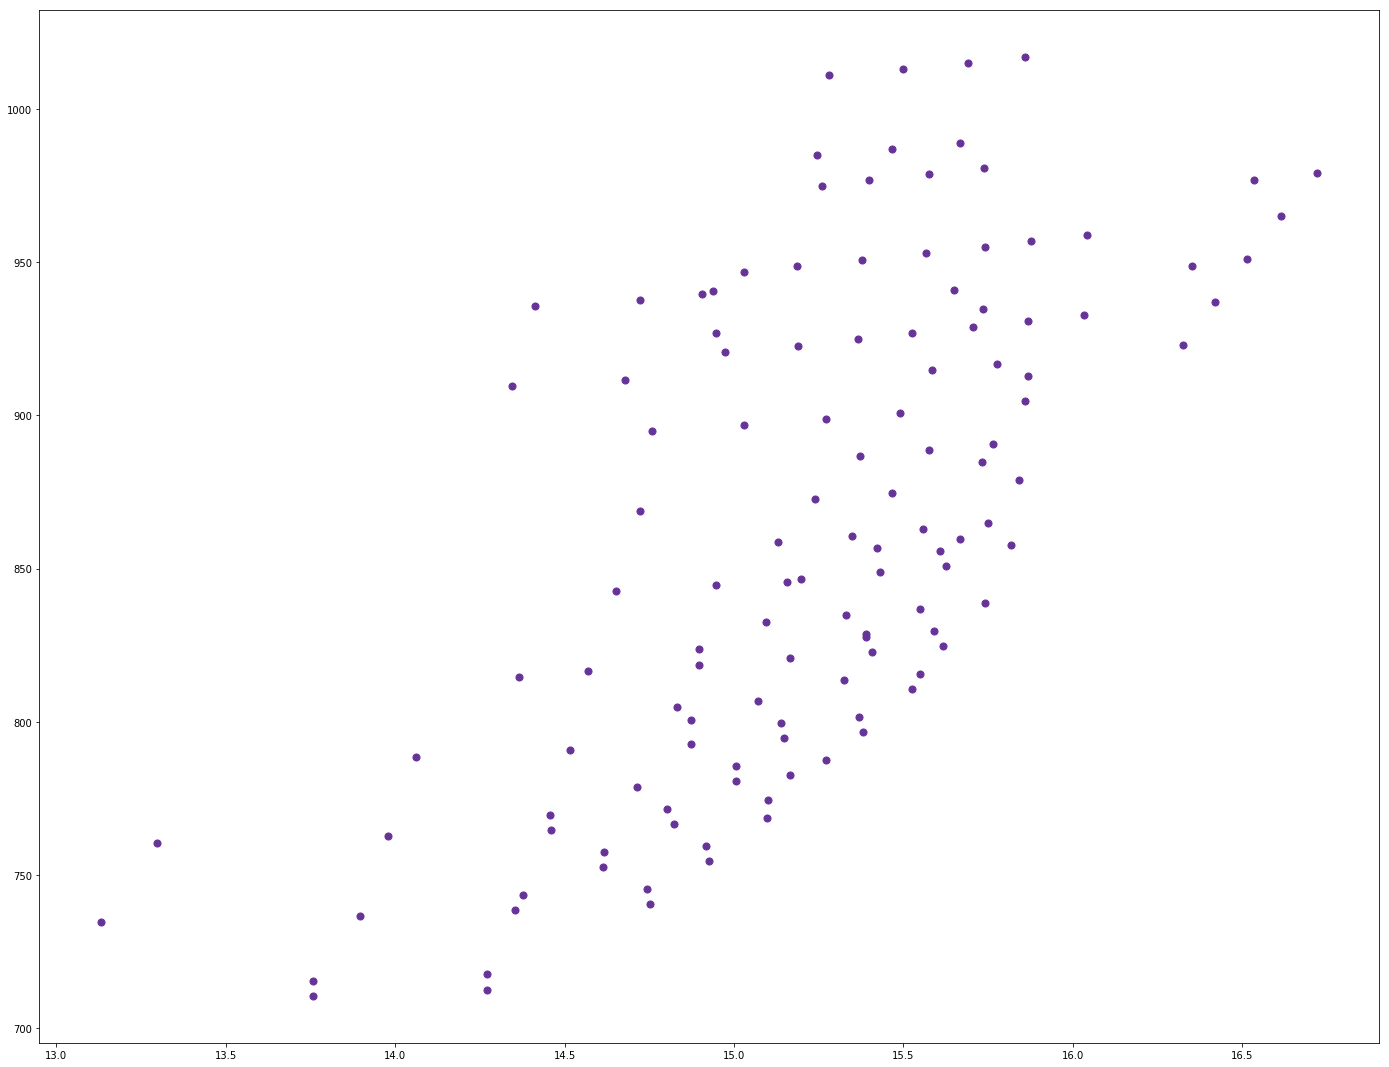

In [126]:

plt.gcf().set_size_inches(24,19)
plt.scatter(data_gk_tags['rt'], data_gk_tags['mz'], color = 'rebeccapurple', s = 50)

In [135]:
data_gk_tags

,mz,mzmin,mzmax,rt,rtmin,rtmax,npeaks,.,X171208_pigs_scat1_15_1.100_pos,X171207_pigs_BF1_10_1.50_pos,...,X171208_pigs_scat2_2_1.100_pos,X171208_pigs_scat2_3_1.100_pos,X171208_pigs_scat2_6_1.100_pos,X171208_pigs_scat2_8_1.100_pos,X171208_pigs_scat2_9_1.100_pos,isotopes,adduct,pcgroup,adduct_annot,lm_id
1606,710.628200,710.619502,710.631196,13.758933,771.661,828.181,76,75,0.614370,0.625769,...,0.637201,0.616369,0.623169,0.634419,0.624194,[340][M]+,[M+H+NH3]+ 692.595,129,M+NH4;M+NH4;M+NH4;M+NH4,LMGL03012633;LMGL03012692;LMGL03013180;LMGL030...
1618,712.643653,712.641264,712.646902,14.272367,853.673,900.335,77,75,0.613369,0.613866,...,0.603350,0.600988,0.602548,0.609517,0.605982,NaN,NaN,505,M+NH4;M+NH4;M+NH4;M+NH4,LMGL03012632;LMGL03012660;LMGL03012691;LMGL030...
1620,715.583984,715.581310,715.587002,13.758383,823.887,828.181,74,73,0.589131,0.596423,...,0.610012,0.589327,0.597462,0.606634,0.595723,[343][M]+,[M+Na]+ 692.595,129,M+H;M+NH4;M+NH4;M+NH4;M+NH4;M+Na;M+Na;M+Na;M+Na,LMGL03012642;LMSP0501AA33;LMSP0501AA55;LMSP050...
1626,717.599014,717.596309,717.602006,14.272450,853.182,858.590,72,72,0.578776,0.571601,...,0.564213,0.561404,0.568881,0.572252,0.566335,[345][M]+,NaN,509,M+H;M+H;M+H;M+NH4;M+NH4;M+NH4;M+NH4;M+Na;M+Na;...,LMGL03012620;LMGL03012640;LMGL03012641;LMSP050...
1685,734.629053,734.626275,734.632169,13.132883,785.286,791.315,63,63,0.578331,0.563048,...,0.578786,0.555991,0.566735,0.587236,0.580092,NaN,NaN,156,M+NH4;M+NH4;M+NH4,LMGL03012620;LMGL03012640;LMGL03012641
1689,736.644115,736.633471,736.647533,13.897233,786.406,835.977,83,75,0.640400,0.660133,...,0.651230,0.626046,0.633995,0.663215,0.648946,[366][M]+,[M+H+NH3]+ 718.61,96,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMGL03012639;LMGL03012663;LMGL03012783;LMGL030...
1693,738.658089,738.647117,738.662676,14.354533,760.470,864.987,139,77,0.662251,0.686371,...,0.685458,0.654365,0.662435,0.686200,0.676052,[368][M]+,NaN,512,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH...,LMGL03012638;LMGL03012696;LMGL03012753;LMGL030...
1697,740.673808,740.667019,740.678166,14.752250,860.732,915.884,145,75,0.662444,0.659348,...,0.653095,0.643223,0.646614,0.654801,0.655181,[369][M]+,[M+H+NH3]+ 722.64,34,M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4;M+NH4,LMGL03012616;LMGL03012637;LMGL03012662;LMGL030...
1705,743.615082,743.612247,743.618222,14.377767,860.684,864.495,76,75,0.636075,0.655769,...,0.652267,0.625275,0.634885,0.656656,0.642959,[371][M]+,NaN,515,M+H;M+H;M+H;M+H;M+H;M+NH4;M+NH4;M+NH4;M+Na;M+N...,LMGL03012649;LMGL03012705;LMGL03013221;LMGL030...
1717,745.629633,745.621535,745.633446,14.744633,860.491,886.224,94,75,0.619889,0.614307,...,0.607678,0.601376,0.603711,0.609196,0.606791,[375][M]+,[M+Na]+ 722.64,34,M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+H;M+NH4;...,LMGL03012648;LMGL03012703;LMGL03012704;LMGL030...
